In [1]:
%reset

In [2]:
import os
from glob import glob 
import nibabel as nib
from matplotlib import pyplot as plt
import benford as bf
import numpy as np
import pandas as pd 
from numpy.random import seed
from numpy.random import rand

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
import subprocess
from pandas.plotting import table 
from sklearn_extensions.kernel_regression import KernelRegression
from matplotlib.font_manager import FontProperties

In [3]:
dataMRI = ('../input')
resultsDir = ('../output')
typeImage = 't1weighted.nii.gz'
extension = 'pdf'

In [4]:
confidenceValue = 95
degreesFreedom = 8

In [5]:
pathMRI = sorted(glob(dataMRI + '/**/' + typeImage, recursive=True))
SIZE = len(pathMRI)

In [6]:
def load_image(filePath):
    image = nib.load(filePath)
    return image

def length_of_decimals(data):
    numMax = data.max()
    integerPart = int(numMax) # the number's integer part
    lengthNum = len(str(integerPart))
    decimals = 19 - lengthNum
    return decimals

def ricianDistribution(img3D, sd, n, fixedSedd):
    if sd==0:
        return img3D
    np.random.seed(fixedSedd)
    distributionRandom1 = np.random.normal(size = img3D.shape)
    distributionRandom2 = np.random.normal(size = img3D.shape)
    # Generate the noise
    x = sd * n * distributionRandom1 + img3D
    y = sd * n * distributionRandom2
    module = np.sqrt(pow(x, 2) + pow(y, 2))
    # Return the image with noise 
    return  module

def bhattacharyya_distance(distribution1, distribution2):
    return -np.log(bhattacharyya_coefficient(distribution1, distribution2))

def bhattacharyya_coefficient(distribution_1, distribution_2):
    return np.sum(np.sqrt(distribution_1 * distribution_2))

def kullbackLeibler_divergence(distribution_1, distribution_2):
    return np.sum(np.where(distribution_1 != 0, distribution_1 * np.log(distribution_1/ distribution_2),0))

def benfordComparative(img1D, decimal, confidenceVal, df):
    fd_img = bf.first_digits(img1D, digs=1, decimals=decimal, MAD=False, confidence=confidenceVal, chi_square=False, KS=False, show_plot=False) 
    # Parameters
    bc = bhattacharyya_coefficient(fd_img.Found, fd_img.Expected)
    kd = kullbackLeibler_divergence(fd_img.Found, fd_img.Expected)
    # List with all values
    return [bc, kd]

In [8]:
column_names = ["Noise", "Bhattacharyya_Coefficient", "KullbackLeiber_Divergence"]
df = pd.DataFrame(columns = column_names)

In [73]:
seed(1)
# 20 random samples from a uniform distribution over [0, 1)
values_noise = rand(20)*0.1
values_noise = values_noise/10

In [9]:
for i_img in range(0, SIZE):
    #It indicates the repository we are in: HLN=0, MMRR=1, NKI-RS=2, NKI-TRT=3
    i_rep = 2

    # Controlde seed
    seed(i_rep+i_img)
    # 20 random samples from a uniform distribution over [0, 1)
    values_noise = rand(20)*0.1

    # Load the image
    image_loaded = load_image(pathMRI[i_img])

    # Define actual image in 3D format
    actualImage = image_loaded.get_fdata()

    # Add 10 different noisy to each MRI, according to sd_range variable
    for noise in range(0, len(values_noise)):
        # Apply Rician noise
        image = ricianDistribution(
                        img3D=actualImage, 
                        sd=values_noise[noise], 
                        n=actualImage.max()-actualImage.min(), 
                        fixedSedd=i_rep + i_img)

        # Images3D list (to plot out of here)
        #imageList3D.append(image)

        # Fast Fourier Transform
        image_FFT = np.fft.fftn(image).astype(np.int64)
        # Allowed decimals according to firs_digit function (benford package)
        ld_FFT = length_of_decimals(image_FFT)
        # Compare MRI distribution with Benford distribution. BC_FFT and KL_FFT are the matching measures.
        BC_FFT, KL_FFT = benfordComparative(img1D=image_FFT.ravel(), 
                                            decimal=ld_FFT, 
                                            confidenceVal=confidenceValue, 
                                            df=degreesFreedom)


        # Append to dataframe
        to_append = [values_noise[noise], BC_FFT, KL_FFT]
        df_length = len(df)
        df.loc[df_length] = to_append

h 12582826 registries.
First_1_Dig
1    0.377345
2    0.194799
3    0.097646
4    0.065589
5    0.057383
6    0.054639
7    0.052483
8    0.050981
9    0.049135
Name: Found, dtype: float64

Test performed on 12582826 registries.
Discarded 0 records < 1 after preparation.

The entries with the significant positive deviations are:

             Expected     Found     Z_score
First_1_Dig                                
1            0.301030  0.377345  590.155818
2            0.176091  0.194799  174.220544
9            0.045757  0.049135   57.333476
<ipython-input-9-8286ad101a5c>:29: ComplexWarning: Casting complex values to real discards the imaginary part
  image_FFT = np.fft.fftn(image).astype(np.int64)

Initialized sequence with 12582850 registries.
First_1_Dig
1    0.371697
2    0.205518
3    0.105185
4    0.066138
5    0.054968
6    0.051621
7    0.049748
8    0.048234
9    0.046891
Name: Found, dtype: float64

Test performed on 12582850 registries.
Discarded 0 records < 1 after prep

In [10]:
#Save at .csv file
df.to_csv(os.path.join(resultsDir, 'BC_and_KL_20randomRicianNoises_MRI' + '.csv'), sep=',', header=True)

In [11]:
def parameters_regressors(dfTr, dfTest, column):
    X_train = np.array(dfTr[column]).reshape(-1,1)
    y_train = dfTr.Noise

    X_test = np.array(dfTest[column]).reshape(-1,1)
    y_test = dfTest.Noise

    regressors(column = column, 
               x = X_train, 
               y = y_train, 
               xTest = X_test, 
               yTest = y_test,
               outputFile_name = outputFile_name + '_' + column)

In [12]:
def regressors(column, x, y, xTest, yTest, outputFile_name):
    # Model's regressors
    reg_lr = LinearRegression()
    reg_polyFeat = PolynomialFeatures(degree=2) #degree=2 worse to degree=3, degree=4 similar to degree=3
    reg_rf = RandomForestRegressor()

    # Necessary transformations
    x_poly = reg_polyFeat.fit_transform(x)
    x_test_poly = reg_polyFeat.fit_transform(xTest)
    model = linear_model.LinearRegression()

    # Regressors's models
    reg_lr.fit(x, y)
    model.fit(x_poly, y)
    reg_rf.fit(x, y)

    # Predictions with test population
    pred_lr = reg_lr.predict(xTest)
    pred_poly = model.predict(x_test_poly)
    pred_rf = reg_rf.predict(xTest)

    # MSE regressors
    MSE_lr = round(mean_squared_error(yTest, pred_lr), 10)
    MSE_poly = round(mean_squared_error(yTest, pred_poly), 10)
    MSE_rf = round(mean_squared_error(yTest, pred_rf), 10)

    # Dataframe with MSE
    regressors_names = ['Linear Regression', 'Polynomial Features', 'Random Forest']
    
    dict = {'Regressors': regressors_names,
            'MSE': [MSE_lr, MSE_poly, MSE_rf]}

    df_regressors = pd.DataFrame(dict)

    fig, ax = plt.subplots(figsize=(4, 1))
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')
    table = ax.table(cellText=df_regressors.values, 
             colLabels=df_regressors.columns, 
             loc='center', cellLoc='center', colLoc='center', edges='closed')
    fig.tight_layout()
    
    P = []

    for key, cell in table.get_celld().items():
            row, col = key
            P.append(cell)
   
    for xTable in P[6:]:
           xTable.set_text_props(fontproperties=FontProperties(weight='bold'))


    plt.savefig(os.path.join(resultsDir, outputFile_name + '_MSE.pdf'))


    # r2
    r2_lr = round(r2_score(yTest, pred_lr), 10)
    r2_poly =  round(r2_score(yTest, pred_poly), 10)
    r2_rf =  round(r2_score(yTest, pred_rf), 10)

    dict = {'Regressors': regressors_names,
            'r2': [r2_lr, r2_poly, r2_rf]}

    df_regressors = pd.DataFrame(dict)

    fig, ax = plt.subplots(figsize=(4, 1))
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')
    table = ax.table(cellText=df_regressors.values, 
             colLabels=df_regressors.columns, 
             loc='center', cellLoc='center', colLoc='center', edges='closed')
    fig.tight_layout()
    
    P = []

    for key, cell in table.get_celld().items():
            row, col = key
            P.append(cell)
   
    for xTable in P[6:]:
           xTable.set_text_props(fontproperties=FontProperties(weight='bold'))


    plt.savefig(os.path.join(resultsDir, outputFile_name + '_r2.pdf'))


    # Plot regressors
    
    # Equally spaced intervals between the start and stop values. 
    x_column = np.linspace(df[column].min(), df[column].max(), 200)
    xTest_plot = x_column.reshape(-1,1)

    # Predictions with test_plot population
    pred_rf_plot = reg_rf.predict(xTest_plot)
    pred_lr_plot = reg_lr.predict(xTest_plot)

    xTest_plot_poly = reg_polyFeat.fit_transform(xTest_plot)
    pred_poly_plot = model.predict(xTest_plot_poly)


    regressors_plot(x_train = x, 
                    y_train = y, 
                    x_test = xTest_plot, 
                    pred1 = pred_lr_plot, 
                    pred2 = pred_poly_plot, 
                    pred3 = pred_rf_plot, 
                    outputFile_name = outputFile_name,
                    column = column)

In [13]:
def regressors_plot(x_train, y_train, x_test, pred1, pred2, pred3, outputFile_name, column):
    plt.figure()
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)

    plt.scatter(x_train, y_train, alpha=0.2, color='black')

    plt.plot(x_test, pred1, 'red', label='LinearRegression', linewidth=2)
    plt.plot(x_test, pred2, 'lime', label='PolynomicRegressor', linewidth=2)
    plt.plot(x_test, pred3, 'blue', label='RandomForestRegressor', linewidth=2)
    plt.ylabel('Predicted noise', size=20)

    plt.ylim(-0.02, 0.1)
    if (column == 'KulbackLeibler_Divergence'):
        column = 'Kullback-Leibler divergence'
    else:
        column = 'Bhattacharyya coefficient'

    plt.xlabel(column, size=20)
    plt.title('')
    plt.tick_params(axis='both', labelsize=20)

    plt.savefig(os.path.join(resultsDir, outputFile_name + '_scatterplot.pdf'))

In [14]:
# Size of repository
SIZE_df = len(df)
    
# Divide population
size_training1 = int(SIZE_df * 0.8)
size_training = np.random.randint(0, high=SIZE_df, size=int(SIZE_df * 0.8), dtype='l') #  quitar que pueda repetir
df_training = df.iloc[size_training]

df_test = df.iloc[size_training1+1:len(df)]

#outputFile_name
outputFile_name = 'MRI'

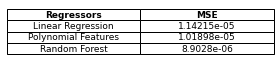

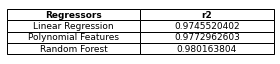

<Figure size 432x288 with 0 Axes>

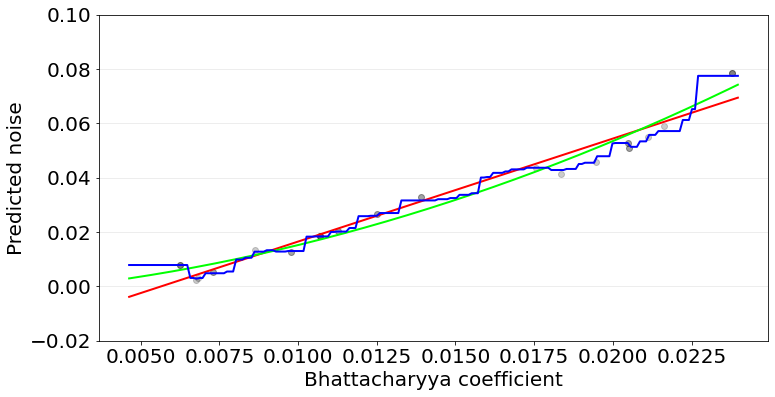

In [15]:
# Kulback-Leibles divergence
parameters_regressors(dfTr = df_training, 
                     dfTest = df_test, 
                     column = 'KullbackLeiber_Divergence')

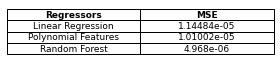

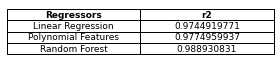

<Figure size 432x288 with 0 Axes>

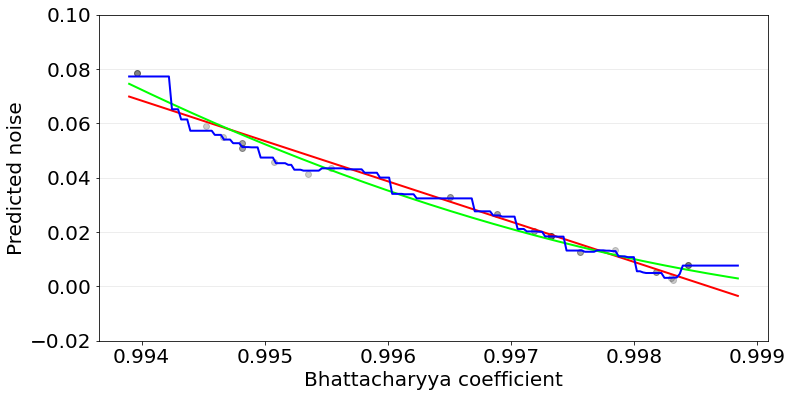

In [16]:
# Bhattacharyya coefficient
parameters_regressors(dfTr = df_training, 
                      dfTest = df_test, 
                      column = 'Bhattacharyya_Coefficient')